**Imports and installations**

In [1]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.callbacks import EarlyStopping
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
import resnet_cifar10
!pip install optuna
import optuna
import xlwt
from xlwt import Workbook
wb = Workbook()
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras import backend as K 
import time
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_auc_score
# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

--2021-07-17 08:48:05--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2021-07-17 08:48:05 (58.0 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]

     |████████████████████████████████| 307kB 13.6MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 174kB 16.9MB/s 
     |████████████████████████████████| 112kB 23.8MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 143kB 20.8MB/s 
     |█████████████████████████████

# Models

**Deep Ensemble model:**

In this section we'll define the Deep Ensemble model. This is a model that contains several deep networks that combined to one model using ensemble learning method. It defines the fit and predict methods. The predict function aggregate the results from the different deep networks using argmax.  

In [ ]:
class DeepEnsemble(BaseEstimator):
    # init the model members
    def __init__(self):
        self.dictionary = {'ensemble_members': []}
        members = []
        # go over the different models
        for i in range(3):
          # Create model
          model = get_training_model()
          members.append(model)
        self.dictionary['ensemble_members'] = members
        
    # set optimizer for the model members
    def set_model_params(self, opt):
      for member in self.dictionary['ensemble_members']:
        member.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # fit the model members
    def fit(self, train_ds, val_ds):
      for model in self.dictionary['ensemble_members']:    
        model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=0)

      return self.dictionary

    # predict the classes using aggregation of the results from the members
    def predict(self, x):
      # make predictions
      yhats = [model.predict(x/255.) for model in self.dictionary['ensemble_members']]
      yhats = np.array(yhats)
      # sum across ensemble members
      summed = np.sum(yhats, axis=0)
      # argmax across classes
      result = np.argmax(summed, axis=1)
      return result

    # predict the classes probabilities using aggregation of the results from the members
    def predict_proba(self, x):
      # make predictions
      yhats = [model.predict(x/255.) for model in self.dictionary['ensemble_members']]
      yhats = np.array(yhats)
      # sum across ensemble members
      summed = np.sum(yhats, axis=0)
      # normalize probabilites
      for i in range(len(summed)):
        sum = np.sum(summed[i])
        for j in range(len(summed[i])):
          summed[i][j] = summed[i][j] / sum

      return summed

**Improved Deep Ensemble model:**

In order to improve the Deep Ensemble model, we used the Boosting technique.

In [ ]:
class ImprovedDeepEnsemble(BaseEstimator):
    # init the model members
    def __init__(self):
        self.dictionary = {'ensemble_members': []}
        members = []
        # go over the different models
        for i in range(3):         
          # Create model
          model = get_training_model()
          members.append(model)
        self.dictionary['ensemble_members'] = members        

    # set optimizer for the model members
    def set_model_params(self, opt):
      for member in self.dictionary['ensemble_members']:
        member.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # predict the class probabilities
    def predict_proba(self, x_test, y_test):
      y_pred_final = pd.DataFrame()
      y_test_final = pd.DataFrame()
      y_test = pd.DataFrame(y_test)

      for model in self.dictionary['ensemble_members']:    
        # predict and find the max probability
        y_pred_prob = pd.DataFrame(model.predict(x_test/255.))
        y_pred_prob_max = pd.DataFrame(y_pred_prob.max(axis=1))

        # find indexes of samples that pass and didn't pass the threshold
        under_threshold_indexes = pd.Index(y_pred_prob_max[y_pred_prob_max[0] < 0.6].index.tolist())
        all_indexes = pd.Index(y_pred_prob.index)
        over_threshold_indexes = all_indexes.difference(under_threshold_indexes)


        # add pred results of test samples that pass the threshold
        rows = y_pred_prob.iloc[over_threshold_indexes]
        y_pred_final = y_pred_final.append(rows)
        y_test_final = y_test_final.append(y_test.iloc[over_threshold_indexes])

        # stop the training if all samples pass the required threshold
        if len(under_threshold_indexes) == 0:
          break
        # define the test set again
        else:
          x_test = x_test[under_threshold_indexes]
          y_test = y_test.iloc[under_threshold_indexes]
      
      # predict the left test set
      if len(under_threshold_indexes) > 0:
          rows = y_pred_prob.iloc[under_threshold_indexes]
          y_pred_final = y_pred_final.append(rows)
          y_test_final = y_test_final.append(y_test)


      y_test_final = y_test_final.values.tolist()
      y_test_final = np.array(y_test_final)
      y_pred_final = y_pred_final.to_numpy()

      return y_test_final, y_pred_final

    # fit and predict the classes probabilities
    def fit_predict(self, train_ds, val_ds, x_test, y_test):
      total_training_time = 0
      total_predicting_time = 0
      y_pred_final = pd.DataFrame()
      y_test_final = pd.DataFrame()
      y_test = pd.DataFrame(y_test)

      for model in self.dictionary['ensemble_members']:    
        # fit the model
        start = time.time()
        model.fit(train_ds, validation_data=val_ds, epochs=3, verbose=0)
        end = time.time()
        total_training_time = total_training_time + (end - start)

        # predict and find the max probability
        start = time.time()
        y_pred_prob = pd.DataFrame(model.predict(x_test/255.))
        end = time.time()
        total_predicting_time = total_predicting_time + (end - start)
        y_pred_prob_max = pd.DataFrame(y_pred_prob.max(axis=1))

        # find indexes of samples that pass and didn't pass the threshold
        under_threshold_indexes = pd.Index(y_pred_prob_max[y_pred_prob_max[0] < 0.6].index.tolist())
        all_indexes = pd.Index(y_pred_prob.index)
        over_threshold_indexes = all_indexes.difference(under_threshold_indexes)


        # add pred results of test samples that pass the threshold
        rows = y_pred_prob.iloc[over_threshold_indexes]
        y_pred_final = y_pred_final.append(rows)
        y_test_final = y_test_final.append(y_test.iloc[over_threshold_indexes])

        # stop the training if all samples pass the required threshold
        if len(under_threshold_indexes) == 0:
          break
        # define the test set again
        else:
          x_test = x_test[under_threshold_indexes]
          y_test = y_test.iloc[under_threshold_indexes]
      
      # predict the left test set
      if len(under_threshold_indexes) > 0:
          rows = y_pred_prob.iloc[under_threshold_indexes]
          y_pred_final = y_pred_final.append(rows)
          y_test_final = y_test_final.append(y_test)


      y_test_final = y_test_final.values.tolist()
      y_test_final = np.array(y_test_final)
      y_pred_final = y_pred_final.to_numpy()

      # return results
      return y_test_final, y_pred_final, total_training_time, total_predicting_time

**Help functions:**

In this section there are the following functions:

* get_training_model - return instance of ResNet model
* normalize - converts the samples to be represented in float32 form
* augment - adding data augmentation 

In [ ]:
# return instance of ResNet model
def get_training_model():
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)
    
    return model

# the function converts the samples to be represented in float32 form
def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

# Adding data augmentation
def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    
    return image, label

# Datasets

**Load datasets:**

In this section we will first load the CIFAR10 dataset. Then, we will split it to smaller subsets that will be used as different datasets for the next phase. 

In [ ]:
SUBSET_NUM = 120

# The function receives X and y sets and split them to 10 datasets 
def split_dataset_by_subset_num(X, y):
  return np.split(X, SUBSET_NUM), np.split(y, SUBSET_NUM)


In [ ]:
# Load the training and testing sets of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Concatenate train and test images
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# split the sets to small datasets
X_subsets, y_subsets = split_dataset_by_subset_num(X, y)


170500096/170498071 [==============================] - 6s 0us/step


# Cross validation

In this section we defined the different functions that required for the optimization process - using Optuna library. We created two functions for each algorithm - one for creating the train objective that finds the best parameters of the model according to the accuracy score. The second one - evaluate objective, which uses the best parameters found in the train, in order to evaluate the different metrics.

In [ ]:
from sklearn.metrics import precision_score
!pip install pycm
from pycm import ConfusionMatrix
from numpy import mean, std
import warnings

# constants 
BATCH_SIZE = 128

# the function returns the base model of InceptionV3 without the top layer 
def get_inception_model():
  pre_trained_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape=(128, 128, 3))
  pre_trained_model.trainable = False
  return pre_trained_model

# the function creates an objective of Deep Ensemble model and returns the best accuracy score
def deep_ens_train_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  model = DeepEnsemble()
  optimizer_options = ["Adam", "RMSprop"]
  optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
  if optimizer_selected == "RMSprop":
      lr = trial.suggest_float("rmsprop_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = RMSprop(learning_rate=lr)
  elif optimizer_selected == "Adam":
      lr = trial.suggest_float("adam_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = Adam(learning_rate=lr)

  model.set_model_params(opt)

  # train the model
  model.fit(train_ds, val_ds)
  # predict and calculate accuracy
  yhat = model.predict(x_test)
  accuracy = accuracy_score(y_test, yhat)

  return accuracy

# the function creates an objective of Improved Deep Ensemble model and returns the best accuracy score
def improved_deep_ens_train_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  model = ImprovedDeepEnsemble()
  optimizer_options = ["Adam", "RMSprop"]
  optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
  if optimizer_selected == "RMSprop":
      lr = trial.suggest_float("rmsprop_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = RMSprop(learning_rate=lr)
  elif optimizer_selected == "Adam":
      lr = trial.suggest_float("adam_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = Adam(learning_rate=lr)

  model.set_model_params(opt)

  # train the model and predict
  y_test, yhat, total_training_time, total_predicting_time = model.fit_predict(train_ds, val_ds, x_test, y_test)
  yhat = np.argmax(yhat, axis=1)
  # calculate accuracy
  accuracy = accuracy_score(y_test, yhat)

  return accuracy  

# the function receives the y_test, y classes probabilities and y probabilities and y_test_binary and returns the following metrics: 
# accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve
def evaluate_metrics(y_test, yhat, y_probs, y_test_binary):
  accuracy = accuracy_score(y_test, yhat)

  # calculate TPR & FPR
  cm = ConfusionMatrix(actual_vector=y_test, predict_vector=yhat)
  TPR = cm.overall_stat['TPR Micro']
  FPR = cm.overall_stat['FPR Micro']

  # calculate auc under PR curve
  average_precision = dict()
  average_precision["micro"] = average_precision_score(y_test_binary, y_probs, average="micro")

  # calculate precision
  precision = precision_score(y_test, yhat, average="micro")

  # calculate auc
  roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')

  return accuracy, TPR, FPR, precision, roc_auc, average_precision["micro"]

# the function receives the y_test, y classes probabilities and y probabilities and y_test_binary and calculate the metrics for the improved algorithm 
# the metrics: accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve
def evaluate_metrics_improved_deep(y_test, yhat, y_probs, y_test_binary, y_test_probs):
  accuracy = accuracy_score(y_test, yhat)

  # calculate TPR & FPR
  cm = ConfusionMatrix(actual_vector=y_test, predict_vector=yhat)
  TPR = cm.overall_stat['TPR Micro']
  FPR = cm.overall_stat['FPR Micro']

  # calculate auc under PR curve
  average_precision = dict()
  average_precision["micro"] = average_precision_score(y_test_binary, y_probs, average="micro")

  # calculate precision
  precision = precision_score(y_test, yhat, average="micro")

  # calculate auc
  roc_auc = roc_auc_score(y_test_probs, y_probs, multi_class='ovr')

  return accuracy, TPR, FPR, precision, roc_auc, average_precision["micro"]

# the function creates an objective with the best trial of the Deep Ensemble model and evaluate the different metrics
def deep_ens_evaluate_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  model = DeepEnsemble()
  optimizer_options = ["Adam", "RMSprop"]
  optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
  if optimizer_selected == "RMSprop":
      lr = trial.suggest_float("rmsprop_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = RMSprop(learning_rate=lr)
  elif optimizer_selected == "Adam":
      lr = trial.suggest_float("adam_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = Adam(learning_rate=lr)

  model.set_model_params(opt)
  
  # calculate fit runtime
  start = time.time()
  model.fit(train_ds, val_ds)
  end = time.time()
  training_time = end - start

  # calculate inference time
  start = time.time()
  yhat = model.predict(x_test)
  end = time.time()
  inference_time = (end - start)

  # Binarize the output
  y_test_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6 , 7, 8, 9])
  y_probs = model.predict_proba(x_test)

  # evaluate metrics
  accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc = evaluate_metrics(y_test, yhat, y_probs, y_test_binary)

  return accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc, training_time, inference_time


# the function creates an objective with the best trial of the Improved Deep Ensemble model and evaluate the different metrics
def improved_deep_ens_evaluate_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  model = ImprovedDeepEnsemble()
  optimizer_options = ["Adam", "RMSprop"]
  optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
  if optimizer_selected == "RMSprop":
      lr = trial.suggest_float("rmsprop_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = RMSprop(learning_rate=lr)
  elif optimizer_selected == "Adam":
      lr = trial.suggest_float("adam_learning_rate", (1.6*1e-3)/8, 1.6*1e-3, log=True)
      opt = Adam(learning_rate=lr)

  model.set_model_params(opt)
  
  # calculate fit runtime
  y_test, yhat, total_training_time, total_predicting_time = model.fit_predict(train_ds, val_ds, x_test, y_test)
  yhat = np.argmax(yhat, axis=1)

  # Binarize the output
  y_test_probs, y_probs = model.predict_proba(x_test, y_test)
  y_test_binary = label_binarize(y_test_probs, classes=[0, 1, 2, 3, 4, 5, 6 , 7, 8, 9])

  # evaluate metrics
  accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc = evaluate_metrics_improved_deep(y_test, yhat, y_probs, y_test_binary, y_test_probs)

  return accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc, total_training_time, total_predicting_time

# the function creates an objective of Inception model and returns the best accuracy score
def inception_train_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  pre_trained_model = get_inception_model()
  rate = trial.suggest_float("rate", 0.4, 0.6)

  model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.UpSampling2D((2,2)),
        tf.keras.layers.UpSampling2D((2,2)),
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(10, activation='softmax')
    ] 
  )

  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  model.compile(optimizer=tf.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=30, restore_best_weights=True)
  model.fit(train_ds, epochs=3, verbose=0, validation_data=val_ds, callbacks=[early_stopping])
  yhat = model.predict_classes(x_test)
  accuracy = accuracy_score(y_test, yhat)
  return accuracy

# the function creates an objective with the best trial of the Inception model and evaluate the different metrics
def inception_evaluate_objective(trial, train_ds, val_ds, x_test, y_test):
  K.clear_session()
  pre_trained_model = get_inception_model()
  rate = trial.suggest_float("rate", 0.4, 0.6)

  model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.UpSampling2D((2,2)),
        tf.keras.layers.UpSampling2D((2,2)),
        pre_trained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(10, activation='softmax')
    ] 
  )

  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  model.compile(optimizer=tf.optimizers.Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=30, restore_best_weights=True)

  # calculate fit runtime
  start = time.time()
  model.fit(train_ds, epochs=3, verbose=0, validation_data=val_ds, callbacks=[early_stopping])
  end = time.time()
  training_time = end - start

  # calculate inference time
  start = time.time()
  yhat = model.predict_classes(x_test)
  end = time.time()
  inference_time = (end - start)


  # Binarize the output
  y_test_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6 , 7, 8, 9])
  y_probs = model.predict_proba(x_test)

  # evaluate metrics
  accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc = evaluate_metrics(y_test, yhat, y_probs, y_test_binary)

  return accuracy, TPR, FPR, precision, roc_auc, PR_curve_auc, training_time, inference_time

def initiate_report_df():
  report_df = pd.DataFrame(columns=['Dataset Name','Algorithm Name','Cross Validation',
                             'Hyper-Parameters Values','Accuracy','TPR','FPR',
                             'Precision','AUC','PR-Curve','Training Time','Inference Time'])
  return report_df



     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 573kB 27.8MB/s 


**Cross validation:**

In this section we defined the nested_cross_validation function that does 10 outer cross validation, 3 inner cross validation for the hyper-parameters optimization (with 10 trials for each run).

In [ ]:
# the function creates the train and validation sets
def create_train_and_val_sets(x_train, y_train, train_j, val_j):
  #create the train dataset
  train_ds = tf.data.Dataset.from_tensor_slices((x_train[train_j], y_train[train_j]))
  train_ds = (
      train_ds
      .shuffle(1024)
      .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.experimental.AUTOTUNE)
  )   

  #create the validation dataset
  val_ds = tf.data.Dataset.from_tensor_slices((x_train[val_j], y_train[val_j]))
  val_ds = (
      val_ds
      .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.experimental.AUTOTUNE)
  )

  return train_ds, val_ds

def nested_cross_validation(X, Y, dataset_name, model_name, report_df):
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # configure the cross-validation procedure - outer
    cv_outer = StratifiedKFold(n_splits=10, shuffle=False)
    # enumerate splits
    outer_results = list()
    cv_counter = 1
    for train_i, test_i in cv_outer.split(X, Y):
      x_train = X[train_i]
      y_train = Y[train_i]
      x_test = X[test_i]
      y_test = Y[test_i]
      # configure the cross-validation procedure - inner
      cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
      for train_j, val_j in cv_inner.split(x_train, y_train):
        train_ds, val_ds = create_train_and_val_sets(x_train, y_train, train_j, val_j)

        # create a new study
        study = optuna.create_study(direction='maximize')
        if model_name == 'Deep Ensemble':
          study.optimize(lambda trial: deep_ens_train_objective(trial, train_ds, val_ds, x_test, y_test), n_trials=10)
        elif model_name == 'Improved Deep Ensemble':
          study.optimize(lambda trial: improved_deep_ens_train_objective(trial, train_ds, val_ds, x_test, y_test), n_trials=10)
        else:
          study.optimize(lambda trial: inception_train_objective(trial, train_ds, val_ds, x_test, y_test), n_trials=10)


        best_trial = study.best_trial
        accuracy = best_trial.value

      # # evaluate model
      if model_name == 'Deep Ensemble':
          accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve, training_time, inference_time = deep_ens_evaluate_objective(best_trial, train_ds, val_ds, x_test, y_test)
      elif model_name == 'Improved Deep Ensemble':
        accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve, training_time, inference_time = improved_deep_ens_evaluate_objective(best_trial, train_ds, val_ds, x_test, y_test)
      else:
        accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve, training_time, inference_time = inception_evaluate_objective(best_trial, train_ds, val_ds, x_test, y_test)

      # report progress
      data_row = [dataset_name, model_name, cv_counter, best_trial.params, accuracy, TPR, FPR, precision, roc_auc, auc_PR_curve, training_time, inference_time]
      report_df.loc[len(report_df)] = data_row
      print("finished cv: " + str(cv_counter))
      cv_counter+=1
  return report_df

**Cross Validation - Deep Ensemble**

In this section we performed the cross validation for the Deep Ensemble model with the 20 different datasets.

In [ ]:
from google.colab import drive
drive.mount('drive')
report_df = initiate_report_df()
for i in range (0, 20):
  dataset_name = 'CIFAR-10_subset_' + str(i) 
  report_df = nested_cross_validation(X_subsets[i], y_subsets[i], dataset_name, 'Deep Ensemble', report_df)

report_df.to_csv('drive/My Drive/Colab Notebooks/deep_ensemble_report.csv', index=False)

**Cross Validation - Improved Deep Ensemble**

In this section we performed the cross validation for the Improved Deep Ensemble model with the 20 different datasets.

In [ ]:
from google.colab import drive
drive.mount('drive')
report_df = initiate_report_df()
for i in range (0, 20):
  dataset_name = 'CIFAR-10_subset_' + str(i) 
  report_df = nested_cross_validation(X_subsets[i], y_subsets[i], dataset_name, 'Improved Deep Ensemble', report_df)

report_df.to_csv('drive/My Drive/Colab Notebooks/improved_deep_ensemble_report.csv', index=False)

**Cross Validation - Inception V3**

In this section we performed the cross validation for the Inception model with the 20 different datasets.

In [ ]:
from google.colab import drive
drive.mount('drive')
report_df = initiate_report_df()
for i in range (0, 20):
  dataset_name = 'CIFAR-10_subset_' + str(i) 
  report_df = nested_cross_validation(X_subsets[i], y_subsets[i], dataset_name, 'Inception', report_df)

report_df.to_csv('drive/My Drive/Colab Notebooks/inception_report.csv', index=False)

# Evaluation

**Cross Validation Results:**

First, we saved the results for each algorithm on different csv and combined them manually to one csv file - full_report.

In this section we'll read the full csv report that we wrote during the CV of the different algorithms and datasets.

In [3]:
from google.colab import drive
drive.mount('drive')

full_report = pd.read_csv('drive/MyDrive/ML-Project/full_report.csv')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


We will calculate the average AUC of the 10 cross validation results for each pair of algorithm and dataset.

In [28]:
mean_auc_df = full_report.groupby(['Dataset Name', 'Algorithm Name'])['AUC'].mean().reset_index()
mean_auc_df

,Dataset Name,Algorithm Name,AUC
0,CIFAR-10_subset_0,Deep Ensemble,0.568848
1,CIFAR-10_subset_0,Improved Deep Ensemble,0.503322
2,CIFAR-10_subset_0,Inception,0.497634
3,CIFAR-10_subset_1,Deep Ensemble,0.559002
4,CIFAR-10_subset_1,Improved Deep Ensemble,0.518408
5,CIFAR-10_subset_1,Inception,0.506798
6,CIFAR-10_subset_10,Deep Ensemble,0.529935
7,CIFAR-10_subset_10,Improved Deep Ensemble,0.512779
8,CIFAR-10_subset_10,Inception,0.510439
9,CIFAR-10_subset_11,Deep Ensemble,0.572699


Make a list of the AUC scores for each algorithm

In [30]:
deep_ensemble_auc = mean_auc_df.loc[mean_auc_df['Algorithm Name']  == "Deep Ensemble"]["AUC"].to_list()
improved_deep_ensemble_auc = mean_auc_df.loc[mean_auc_df['Algorithm Name']  == "Improved Deep Ensemble"]["AUC"].to_list()
inception_auc = mean_auc_df.loc[mean_auc_df['Algorithm Name']  == "Inception"]["AUC"].to_list()

**Friedman Test:**

In this section we'll use Friedman test in order to check if all the algorithms perform the same (H0) or not.

In [31]:
from scipy import stats

# perform Friedman Test
stats.friedmanchisquare(deep_ensemble_auc, improved_deep_ensemble_auc, inception_auc)

FriedmanchisquareResult(statistic=32.69999999999999, pvalue=7.930219729907684e-08)

**Post-Hoc Test:**

As we can see, the H0 hypothesis was rejected (P-value<0.05). We will perform the Post-Hoc test in order to test the differences between the algorithms.

In [42]:
!pip install scikit-posthocs
import scikit_posthocs as sp

# perform Post-Hoc Test
sp.posthoc_nemenyi_friedman(mean_auc_df, y_col='AUC', block_col='Dataset Name', group_col='Algorithm Name', melted=True)

,Deep Ensemble,Improved Deep Ensemble,Inception
Deep Ensemble,1.000000,0.002589,0.001000
Improved Deep Ensemble,0.002589,1.000000,0.046567
Inception,0.001000,0.046567,1.000000


We can also see the results using heatmap

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5428f8b050>,
 <matplotlib.colorbar.ColorbarBase at 0x7f541f6e5e50>)

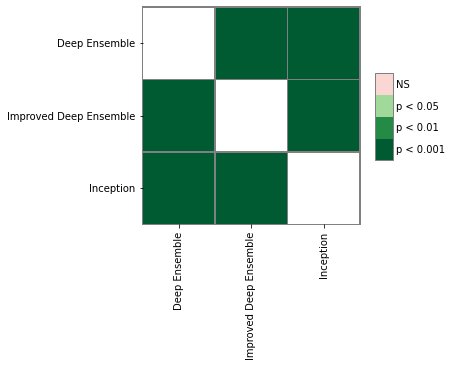

In [37]:
pc = sp.posthoc_conover(mean_auc_df, val_col='AUC', group_col='Algorithm Name')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

As we can see all two pairs of algorithms perform significantly different.

**Evaluation - improved algorithm**

In this section, we will compare between the running times of the Deep Ensemble model and the Improved Deep Ensemble model in order to see if we managed to achieve our main purpose in the suggested algorithm. 

In [5]:
mean_train_time_df = full_report.groupby(['Algorithm Name'])['Training Time'].mean().reset_index()
mean_train_time_df


,Algorithm Name,Training Time
0,Deep Ensemble,12.256998
1,Improved Deep Ensemble,6.786281
2,Inception,6.583463


In [6]:
mean_inference_time_df = full_report.groupby(['Algorithm Name'])['Inference Time'].mean().reset_index()
mean_inference_time_df

,Algorithm Name,Inference Time
0,Deep Ensemble,1.050858
1,Improved Deep Ensemble,0.600875
2,Inception,1.206252


From the results of the mean training time and inference time, we can see that we did managed to improve the running time using the Boosting technique.  